In [ ]:
!wget -q https://emile-barjou.emi.u-bordeaux.fr/assignment3.zip -O assignment3.zip
!unzip -q -o assignment3.zip

# **Acquisition and Reconstruction**
### Assignment 3 : Tomographic reconstrution

The goal of this assignment is to implement a simple version of the tomographic reconstruction, in 2D.

You can use numpy, matplotlib to display your result, and pillow to open the images.
You can also use PyGLM for vector operations, but no other external libraries are authorized.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### I) **Line drawing algorithm (2pts)**

For the reconstruction, we will use a pixel-driven approach (iterating through the pixels of the projection, and for each of them modify the reconstruction.)
To achieve this, we will need a line-drawing algorithm.

**Step 0.0 :** Write a function that take two 2D points as argument and return the coordinates of each cells that are in the path between them. You can look for existing algorithm online (such as Bresenham), but you have to implement it yourself using only Python/Numpy operators.

In [ ]:
def plot_line_low(x0, y0, x1, y1):
  line = []
  dx = x1 - x0
  dy = y1 - y0
  yi = 1
  if dy < 0:
    yi = -1
    dy = -dy
  D = (2 * dy) - dx
  y = y0

  for x in range(x0, x1 + 1):
    line.append([x, y])
    if D > 0:
      y = y + yi
      D = D + (2 * (dy - dx))
    else:
      D = D + 2*dy
  return np.array(line).T

def plot_line_high(x0, y0, x1, y1):
  line = []
  dx = x1 - x0
  dy = y1 - y0
  xi = 1
  if dx < 0:
      xi = -1
      dx = -dx
  D = (2 * dx) - dy
  x = x0

  for y in range(y0, y1 + 1):
    line.append([x, y])
    if D > 0:
      x = x + xi
      D = D + (2 * (dx - dy))
    else:
      D = D + 2*dx
  return np.array(line).T

def plot_line(p1, p2):
    y0, x0 = p1
    y1, x1 = p2
    if abs(y1 - y0) < abs(x1 - x0):
      if x0 > x1:
        return plot_line_low(x1, y1, x0, y0)
      else:
        return plot_line_low(x0, y0, x1, y1)
    else:
      if y0 > y1:
        return plot_line_high(x1, y1, x0, y0)
      else:
        return plot_line_high(x0, y0, x1, y1)

line = plot_line([0,0], [10,5])
print(line)


[[ 0  0  1  1  2  2  3  3  4  4  5]
 [ 0  1  2  3  4  5  6  7  8  9 10]]


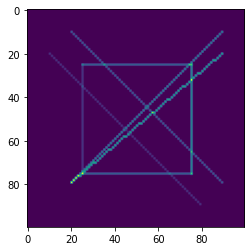

In [ ]:
# testing
canvas = np.zeros((100,100))
line1 = plot_line([10,20], [79,89])
line2 = plot_line([89,79], [20,10])
line3 = plot_line([20,79], [89,10])
line4 = plot_line([89,20], [20,79])

rect1 = plot_line([25,25], [25,75])
rect2 = plot_line([25,75], [75,75])
rect3 = plot_line([75,75], [75,25])
rect4 = plot_line([75,25], [25,25])

canvas[line1[0,:],line1[1,:]] += 1
canvas[line2[0,:],line2[1,:]] += 2
canvas[line3[0,:],line3[1,:]] += 3
canvas[line4[0,:],line4[1,:]] += 4

canvas[rect1[0,:],rect1[1,:]] += 1
canvas[rect2[0,:],rect2[1,:]] += 2
canvas[rect3[0,:],rect3[1,:]] += 3
canvas[rect4[0,:],rect4[1,:]] += 2
plt.imshow(canvas)
plt.show()

**Step 0.1 :** Create a numpy array of size 80 by 80 filled with zeros. Using the previous function, fill the path from \[3,10\] to \[60,75\] with ones and display the result with matplotlib.

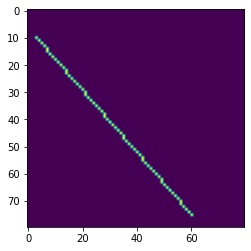

In [ ]:
canvas = np.zeros((80,80))
line = plot_line([3,10], [60,75])
canvas[line[0,:],line[1,:]] = 1
plt.imshow(canvas)
plt.show()

### II) **Parallel 2D reconstruction (4pts + 1pts for performances)**

The reconstructions algorithms are based on two functions : the projection and the backprojection.

The projection is the process done when capturing a radiograph. It reduce the dimension of an object by one (2D->1D or 3D->2D). 

The backprojection is the inverse operation of the projection : it take a projected data and propagate it into a higher dimension object (1D->2D, 2D->3D). Of course, a lot of information is lost in the projection process, so the result of the backprojection carry a less information than the original object. In order to obtain a better approximation, a lot of projections at different positions are needed.

We will only consider the case of circular tomography, where the projections are taken from a single circle around the object. The goal here is to write a backprojector function for various cases : 2D parallel, 2D conical, and 3D conical.

To do this, first, you need to compute for each pixels of the projected data the path in the reconstructed object between the pixel and the source, and add to all element in this path the value of the pixel divided by the length of the path.

For an improved image quality, the path can be also weighted (anti-aliased) to produce a smoother result. In this assignment, you are not asked to do that and can consider all elements in the path to have a weigth of 1.

In the case of a parallel geometry (ie. the rays are all perpendicular to the detector), the voxels have the same size as the pixels, and the distances between the source, the object and the detector don't impact the result.

This type of computations are demanding, espicially in python. Use as much as possible the Numpy functions and try to vectorize your code.

In [ ]:
"""
N-D Bresenham line algo
"""
import numpy as np
def _bresenhamline_nslope(slope):
    """
    Normalize slope for Bresenham's line algorithm.

    >>> s = np.array([[-2, -2, -2, 0]])
    >>> _bresenhamline_nslope(s)
    array([[-1., -1., -1.,  0.]])

    >>> s = np.array([[0, 0, 0, 0]])
    >>> _bresenhamline_nslope(s)
    array([[ 0.,  0.,  0.,  0.]])

    >>> s = np.array([[0, 0, 9, 0]])
    >>> _bresenhamline_nslope(s)
    array([[ 0.,  0.,  1.,  0.]])
    """
    scale = np.amax(np.abs(slope), axis=1).reshape(-1, 1)
    zeroslope = (scale == 0).all(1)
    scale[zeroslope] = np.ones(1)
    normalizedslope = np.array(slope, dtype=np.double) / scale
    normalizedslope[zeroslope] = np.zeros(slope[0].shape)
    return normalizedslope

def _bresenhamlines(start, end, max_iter):
    """
    Returns npts lines of length max_iter each. (npts x max_iter x dimension) 

    >>> s = np.array([[3, 1, 9, 0],[0, 0, 3, 0]])
    >>> _bresenhamlines(s, np.zeros(s.shape[1]), max_iter=-1)
    array([[[ 3,  1,  8,  0],
            [ 2,  1,  7,  0],
            [ 2,  1,  6,  0],
            [ 2,  1,  5,  0],
            [ 1,  0,  4,  0],
            [ 1,  0,  3,  0],
            [ 1,  0,  2,  0],
            [ 0,  0,  1,  0],
            [ 0,  0,  0,  0]],
    <BLANKLINE>
           [[ 0,  0,  2,  0],
            [ 0,  0,  1,  0],
            [ 0,  0,  0,  0],
            [ 0,  0, -1,  0],
            [ 0,  0, -2,  0],
            [ 0,  0, -3,  0],
            [ 0,  0, -4,  0],
            [ 0,  0, -5,  0],
            [ 0,  0, -6,  0]]])
    """
    if max_iter == -1:
        max_iter = np.amax(np.amax(np.abs(end - start), axis=1))
    npts, dim = start.shape
    nslope = _bresenhamline_nslope(end - start)

    # steps to iterate on
    stepseq = np.arange(1, max_iter + 1)
    stepmat = np.tile(stepseq, (dim, 1)).T

    # some hacks for broadcasting properly
    bline = start[:, np.newaxis, :] + nslope[:, np.newaxis, :] * stepmat

    # Approximate to nearest int
    return np.array(np.rint(bline), dtype=start.dtype)

def bresenhamline(start, end, max_iter=-1):
    """
    Returns a list of points from (start, end] by ray tracing a line b/w the
    points.
    Parameters:
        start: An array of start points (number of points x dimension)
        end:   An end points (1 x dimension)
            or An array of end point corresponding to each start point
                (number of points x dimension)
        max_iter: Max points to traverse. if -1, maximum number of required
                  points are traversed

    Returns:
        linevox (n x dimension) A cumulative array of all points traversed by
        all the lines so far.

    >>> s = np.array([[3, 1, 9, 0],[0, 0, 3, 0]])
    >>> bresenhamline(s, np.zeros(s.shape[1]), max_iter=-1)
    array([[ 3,  1,  8,  0],
           [ 2,  1,  7,  0],
           [ 2,  1,  6,  0],
           [ 2,  1,  5,  0],
           [ 1,  0,  4,  0],
           [ 1,  0,  3,  0],
           [ 1,  0,  2,  0],
           [ 0,  0,  1,  0],
           [ 0,  0,  0,  0],
           [ 0,  0,  2,  0],
           [ 0,  0,  1,  0],
           [ 0,  0,  0,  0],
           [ 0,  0, -1,  0],
           [ 0,  0, -2,  0],
           [ 0,  0, -3,  0],
           [ 0,  0, -4,  0],
           [ 0,  0, -5,  0],
           [ 0,  0, -6,  0]])
    """
    # Return the points as a single array
    return _bresenhamlines(start, end, max_iter).reshape(-1, start.shape[-1])

**Step 1.0 :** Open the tiff file "data/sinogram_2d_parallel.tif", store it in a Numpy array, and display it. Each line of the sinogram represent the projection of the image at a given angle.

The parameters of this projections are the following :
 - Parallel aqcuisition geometry
 - 200 projections over 360 degrees (with a regular step)

Each line represent the projection at a specific angle, from 0 to 360°.

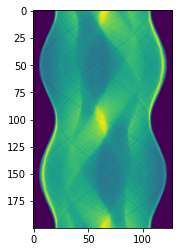

In [ ]:
par_img_proj_file = Image.open('/content/assignment3/data/sinogram_2d_parallel.tif')
par_img_proj = np.array(par_img_proj_file)
plt.imshow(par_img_proj)
plt.show()

**Step 1.1 :** Write a function that take as argument a coordinate on a sinogram line and the angle of this line (and possibly other parameters to represent the geometry) and return the start and end point the path between the pixel determined by (line, angle) and the source, in a parallel geometry.

In [ ]:
def par_line_endpoints(rho, theta):
  x0, y0 = 256, 64 - rho
  r = np.sqrt(x0**2 + y0**2)
  phi = np.arcsin(y0/r)
  det_x, det_y = r * np.cos(phi + theta), r * np.sin(phi + theta)
  src_x, src_y = r * np.cos(np.pi - phi + theta), r * np.sin(np.pi - phi + theta)
  return np.array([[det_x, det_y]], dtype=np.int32), np.array([[src_x, src_y]], dtype=np.int32)

**Step 1.2 :** Using the previous functions, write a 2D backprojector function for parallel geometry, taking as parameters a 2D sinogram and that return the 2D reconstructed image

In [ ]:
import time
def parallel_reconstruction(img_proj):
  t0 = time.time()
  img_rec = np.zeros((1024, 1024), dtype=np.float32)
  cnt_img = np.zeros((1024, 1024), dtype=np.float32)
  for th_index in range(img_proj.shape[0]):
    for rho in range(img_proj.shape[1]):
      theta = 2 * np.pi / img_proj.shape[0] * th_index
      ep = par_line_endpoints(rho, theta)
      line = bresenhamline(*ep).T
      img_rec[line[0,:] + 512, line[1,:] + 512] += img_proj[th_index,rho]
      cnt_img[line[0,:] + 512, line[1,:] + 512] += 1

  cnt_img[cnt_img == 0] = 1
  img_rec /= cnt_img
  return img_rec

**Step 1.3 :** Apply the parallel reconstruction function to the parallel sinogram and display the result

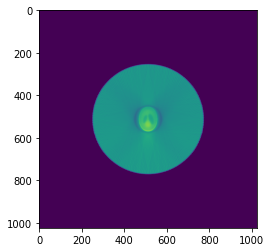

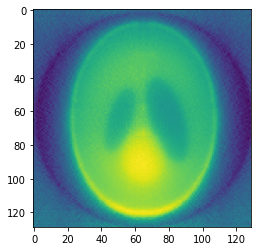

In [ ]:
par_img_rec = parallel_reconstruction(par_img_proj)

plt.imshow(par_img_rec)
plt.show()
plt.imshow(par_img_rec[512-65:512+64,512-65:512+64])
plt.show()

### III) **Cone-beam 2D reconstruction (4pts + 1pts for performances)**

The parallel geometry is simpler to reconstruct, but in practice not used so often because of the complexity of the parallel x-ray generation. A much more common approach is to use a ponctual source, that create a cone-beam geometry. 

This mean that the path now come from the source and go to a pixel on the detector, instead of being perpendicular to the detector.

**Step 2.0 :** Open the tiff file "data/sinogram_2d_cone.tif" and display it.

The parameters of the projection are the following :
 - Spherical aqcuisition geometry
 - 200 projections over 360 degrees
 - source-object distance of 300mm
 - object-detector distance of 400mm
 - Voxel size of 1mm

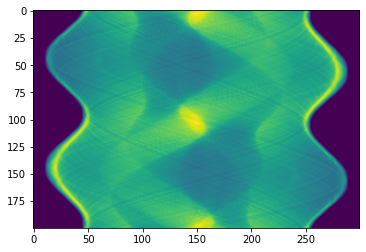

(200, 300)


In [ ]:
cone_img_proj_file = Image.open('/content/assignment3/data/sinogram_2d_cone.tif')
cone_img_proj = np.array(cone_img_proj_file)
plt.imshow(cone_img_proj)
plt.show()
print(cone_img_proj.shape)

**Step 2.1 :** Write a function that take as argument a coordinate on a sinogram line and the angle of this line (and possibly other parameters to represent the geometry) and return the start and end point the path between the pixel determined by (line, angle) and the source, in a cone-beam geometry.

In [ ]:
def cone_line_endpoints(rho, theta):
  x0, y0 = 400, 149 - rho
  r = np.sqrt(x0**2 + y0**2)
  phi = np.arcsin(y0/r)
  det_x, det_y = r * np.cos(phi + theta), r * np.sin(phi + theta)
  src_x, src_y = 300 * np.cos(np.pi + theta), 300 * np.sin(np.pi + theta) # only depends on the rotation of the system
  return np.array([[det_x, det_y]], dtype=np.int32), np.array([[src_x, src_y]], dtype=np.int32)

**Step 2.2 :** Using the previous functions, write a 2D backprojector function for cone-beam geometry, taking as parameters a 2D sinogram and the geometric parameters, and that return the 2D reconstructed image

In [ ]:
def cone_reconstruction(img_proj):
  img_rec = np.zeros((1024, 1024), dtype=np.float32)
  cnt_img = np.zeros((1024, 1024), dtype=np.float32)
  for th_index in range(img_proj.shape[0]):
    for rho in range(img_proj.shape[1]):
      theta = 2 * np.pi / img_proj.shape[0] * th_index
      ep = cone_line_endpoints(rho, theta)
      line = bresenhamline(*ep).T
      img_rec[line[0,:] + 512, line[1,:] + 512] += img_proj[th_index,rho]
      cnt_img[line[0,:] + 512, line[1,:] + 512] += 1

  cnt_img[cnt_img == 0] = 1
  img_rec /= cnt_img
  return img_rec

**Step 2.3 :** Apply the spherical reconstruction function to the spherical sinogram and display the result

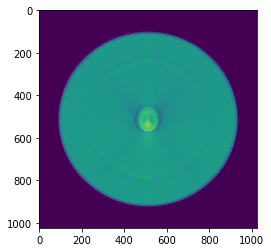

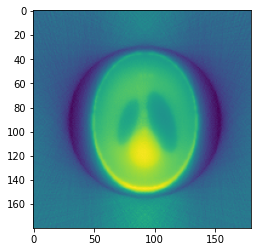

In [ ]:
cone_img_rec = cone_reconstruction(cone_img_proj)

plt.imshow(cone_img_rec)
plt.show()
plt.imshow(cone_img_rec[420:600,420:600])
plt.show()

### IV) **Spherical 3D reconstruction (6pts + 2pt for performances)**

Now we are going to extend this algorithm to 3D.

Going from 2D to 3D means that a lot more computations have to be done. 
Using only python for-loop for the 3D reconstruction will be very slow. It's recommended to use as much as possible the numpy functions to avoid having to use too many for-loop.

 **Step 3.0 :** Like in step 1.0, write a function that return the coordinates of all voxels between two points, but this time in a 3D grid
 

In [ ]:
def print_3d_line(points):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  ax.scatter(points[0,:], points[1,:], points[2,:], marker='^')
  limits = (np.min(points), np.max(points))
  ax.set_xlim3d(*limits)
  ax.set_ylim3d(*limits)
  ax.set_zlim3d(*limits)
  fig.show()

0.0006191730499267578
(2, 10, 3)


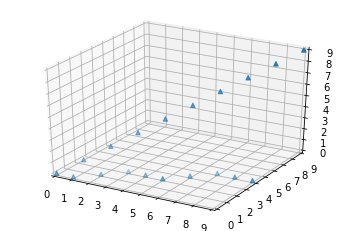

In [ ]:
start_points = np.array([[10,10,10], [10,5,0]])
end_points = np.array([[0,0,0]])

n_lines = start_points.shape[0]

t = time.time()
line = bresenhamline(start_points, end_points)
print(time.time() - t)
print(line.reshape((n_lines, -1, 3)).shape)
print_3d_line(line.T)

**Step 3.1 :** Write a function that take as argument a coordinate on a projection and an angle (and possibly other parameters to represent the geometry) and return the start and end of the path between this pixel and the source in a 3D spherical geometry.

In [ ]:
def src_point(theta, config):
  src_x, src_y, src_z = \
    config['d_src_obj'] * config['pixel_size'] * np.cos(np.pi + theta), \
    config['d_src_obj'] * config['pixel_size'] * np.sin(np.pi + theta), \
    0
  return np.array([[src_x, src_y, src_z]], dtype=np.int32)

def dst_point(rho, z, theta, config):
  x0, y0, z0 = \
    (config['d_src_det'] - config['d_src_obj']) * config['pixel_size'], \
    config['proj_size'][0] / 2 - rho, \
    config['proj_size'][1] / 2 - z
  r = np.sqrt(x0**2 + y0**2)
  phi = np.arcsin(y0/r)
  det_x, det_y, det_z = r * np.cos(phi + theta), r * np.sin(phi + theta), z0
  return np.array([[det_x, det_y, det_z]], dtype=np.int32)

**Step 3.2 :**  Open all the tiff files in "data/projections_3d/" and display one or a few projections

The parameters of this dataset are the following :

 - Spherical aqcuisition geometry
 - The source, the rotation axis and the detector are all aligned
 - 200 projections over 360 degrees
 - Distance source-object : 200mm
 - Distance source-detector : 2000mm
 - Pixel size : 0.5mm by 0.5mm

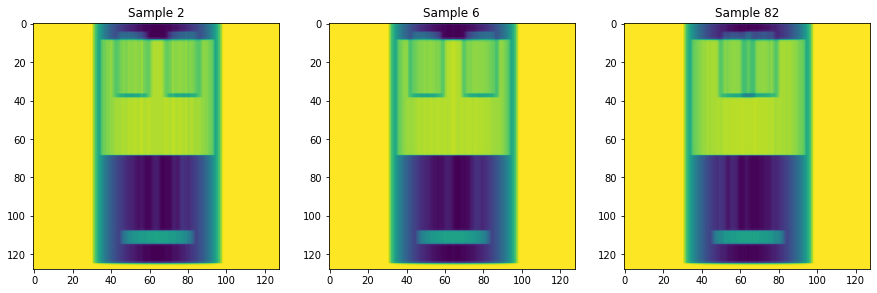

(200, 128, 128)


In [ ]:
import os

path = "/content/assignment3/data/projections_3d"
dir_list = os.listdir(path)

images = [os.path.join(path, x) for x in sorted(dir_list) if x.endswith(".tiff")]
proj = None
for (i, img_path) in enumerate(images):
  img_file = Image.open(img_path)
  img = np.array(img_file)
  if proj is None:
    proj = np.zeros((len(images), *img.shape))
  proj[i,:,:] = img

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
for i, sample in enumerate(sorted(np.random.randint(proj.shape[0], size=3))):
  axs[i].imshow(proj[sample,:,:])
  axs[i].set_title(f"Sample {sample}")
plt.show()

print(proj.shape)

**Step 3.3 :** Create a function that take as argument a list of projection and the geometrical parameters needed, and output the result of the 3D spherical back-projection.

In [ ]:
from tqdm import tqdm

def sphere_reconstruction(img_proj, config):
  print(config)

  size = (150,150,150)

  img_rec = np.zeros(size, dtype=np.float32)
  cnt_img = np.zeros(size, dtype=np.float32)
  for th_index in tqdm(range(img_proj.shape[0])):
    theta = 2 * np.pi / img_proj.shape[0] * th_index

    src = src_point(theta, config)
    rho, z = np.meshgrid(range(img_proj.shape[1]), range(img_proj.shape[2]))

    dst = dst_point(rho, z, theta, config).reshape(1,3,-1).T.squeeze()

    lines = bresenhamline(dst, src).T
    n_points = lines.reshape((dst.shape[0], -1, 3)).shape[1]

    values = np.expand_dims(img_proj[th_index,:,:].flatten(), axis=1)
    values_extended = np.dot(values, np.ones((1, n_points))).flatten()

    point_indexes = np.argwhere(np.max(np.abs(lines), axis=0) < 64)

    img_rec[lines[0,point_indexes] + int(size[0]/2), \
            lines[1,point_indexes] + int(size[1]/2), \
            lines[2,point_indexes] + int(size[2]/2)] += values_extended[point_indexes]
    cnt_img[lines[0,point_indexes] + int(size[0]/2), \
            lines[1,point_indexes] + int(size[1]/2), \
            lines[2,point_indexes] + int(size[2]/2)] += 1
  
  cnt_img[cnt_img == 0] = 1
  img_rec /= cnt_img
  return img_rec

In [ ]:
from tqdm import tqdm

"""
Point-wise line drawing implementation, much slower
"""

def sphere_reconstruction_2(img_proj, config):
  print(config)

  size = (150,150,150)

  img_rec = np.zeros(size, dtype=np.float32)
  cnt_img = np.zeros(size, dtype=np.float32)
  for th_index in tqdm(range(img_proj.shape[0])):
    theta = 2 * np.pi / img_proj.shape[0] * th_index

    src = src_point(theta, config)

    for rho in range(img_proj.shape[1]):
      for z in range(img_proj.shape[2]):
        dst = dst_point(rho, z, theta, config).reshape(1,3,-1).T.squeeze()

        line = bresenhamline(np.expand_dims(dst, axis=0), src).T

        point_indexes = np.argwhere(np.max(np.abs(line), axis=0) < 64)
    
        img_rec[line[0,point_indexes] + int(size[0]/2), \
                line[1,point_indexes] + int(size[1]/2), \
                line[2,point_indexes] + int(size[2]/2)] += img_proj[th_index, rho, z]
        cnt_img[line[0,point_indexes] + int(size[0]/2), \
                line[1,point_indexes] + int(size[1]/2), \
                line[2,point_indexes] + int(size[2]/2)] += 1
  
  cnt_img[cnt_img == 0] = 1
  img_rec /= cnt_img
  return img_rec

**Step 3.4 :** Apply the function to the dataset and display the result of an arbitrary layer

In [ ]:
import gc
rec = None
gc.collect()
if 'rec' in globals():
  del rec


# Spherical aqcuisition geometry
# The source, the rotation axis and the detector are all aligned
# 200 projections over 360 degrees
# Distance source-object : 200mm
# Distance source-detector : 2000mm
# Pixel size : 0.5mm by 0.5mm
config = {
  'n_proj': 200,
  'd_src_obj': 1800, # mm
  'd_src_det': 2000, # mm
  'pixel_size': 0.5, # mm
  'proj_size': (proj.shape[1], proj.shape[2]),
}

rec = sphere_reconstruction(proj, config)

{'n_proj': 200, 'd_src_obj': 1800, 'd_src_det': 2000, 'pixel_size': 0.5, 'proj_size': (128, 128)}


100%|██████████| 200/200 [03:26<00:00,  1.03s/it]


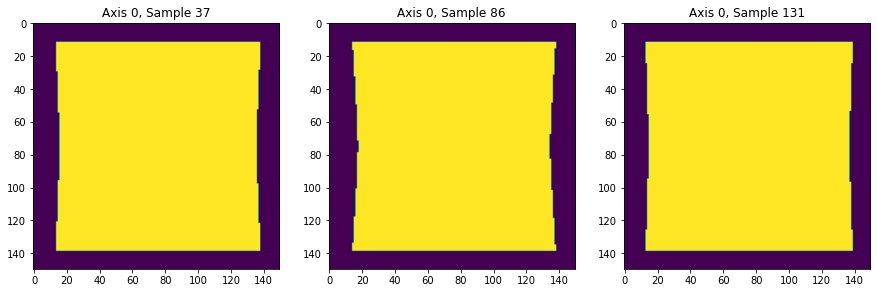

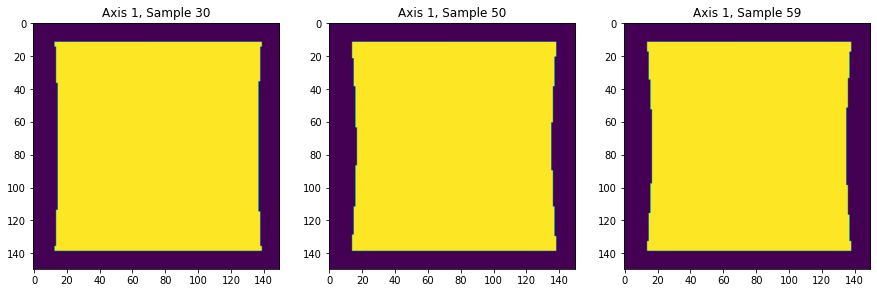

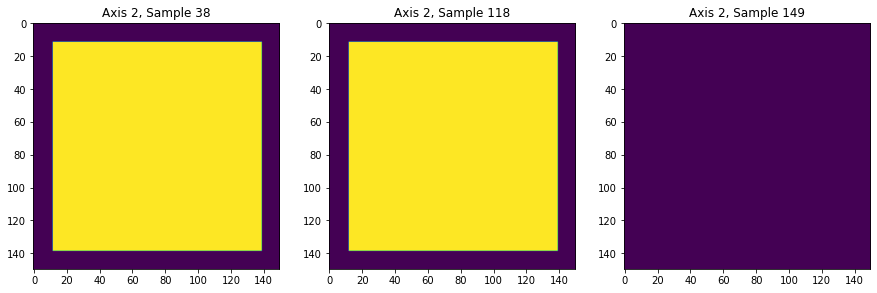

In [ ]:
for axis in range(3):
  fig, axs = plt.subplots(1, 3, figsize=(15, 15))
  for i, sample in enumerate(sorted(np.random.randint(rec.shape[axis], size=3))):
    axs[i].imshow(rec.take(sample, axis=axis))
    axs[i].set_title(f"Axis {axis}, Sample {sample}")
  plt.show()

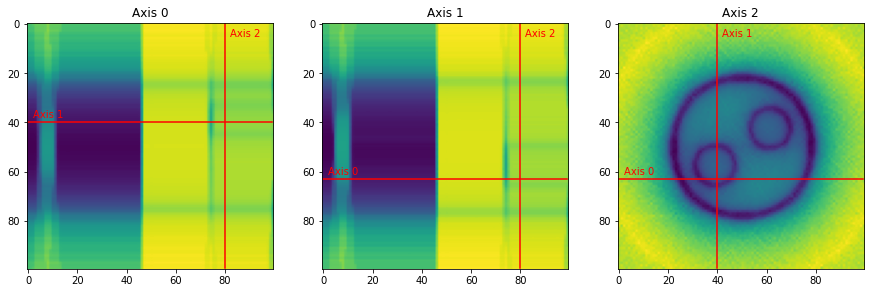

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
center = (np.asarray(rec.shape) / 2).astype(np.int32)
region = (50,50,50)
offset = (13,-10,30)
x, y, z = center
rx, ry, rz = region
cropped = rec[x-rx:x+rx, y-ry:y+ry, z-rz:z+rz]
for axis in range(3):
  axs[axis].imshow(cropped.take(region[axis]+offset[axis], axis=axis))
  if axis == 0:    
    axs[axis].plot([0,2*region[1]-1], [region[1] + offset[1],region[1] + offset[1]], 'r-')
    axs[axis].text(2, region[1] + offset[1] - 2, "Axis 1", c='r')
    axs[axis].plot([region[2] + offset[2],region[2] + offset[2]], [0,2*region[2]-1], 'r-')
    axs[axis].text(region[2] + offset[2] + 2, 5, "Axis 2", c='r')
  if axis == 1:    
    axs[axis].plot([0,2*region[0]-1], [region[0] + offset[0],region[0] + offset[0]], 'r-')
    axs[axis].text(2, region[0] + offset[0] - 2, "Axis 0", c='r')
    axs[axis].plot([region[2] + offset[2],region[2] + offset[2]], [0,2*region[2]-1], 'r-')
    axs[axis].text(region[2] + offset[2] + 2, 5, "Axis 2", c='r')
  if axis == 2:    
    axs[axis].plot([0,2*region[0]-1], [region[0] + offset[0],region[0] + offset[0]], 'r-')
    axs[axis].text(2, region[0] + offset[0] - 2, "Axis 0", c='r')
    axs[axis].plot([region[1] + offset[1],region[1] + offset[1]], [0,2*region[1]-1], 'r-')
    axs[axis].text(region[1] + offset[1] + 2, 5, "Axis 1", c='r')
  axs[axis].set_title(f"Axis {axis}")
plt.show()